# Open Vocabulary Object Segmentation using TAO Mask Grounding DINO

Transfer learning is the process of transferring learned features from one application to another. It is a commonly used training technique where you use a model trained on one task and re-train to use it on a different task. 

Train Adapt Optimize (TAO) Toolkit  is a simple and easy-to-use Python based AI toolkit for taking purpose-built AI models and customizing them with users' own data.

<img align="center" src="https://d29g4g2dyqv443.cloudfront.net/sites/default/files/akamai/TAO/tlt-tao-toolkit-bring-your-own-model-diagram.png" width="1080">

## What is Mask Grounding DINO?

Built on top of [Grounding DINO](https://arxiv.org/abs/2303.05499), Mask Grounding DINO is a NVIDIA proprietary open-set object segmentation model. Mask Grounding DINO can detect and segment arbitrary objects with human inputs such as category names or referring expressions. Compared to Grounding DINO, Mask Grounding DINO has an additional mask branch and mask prediction head.

In TAO, only single type of backbone network is supported: [Swin](https://arxiv.org/abs/2103.14030). In this notebook, we use the pretrained Swin-Tiny Grounding DINO and showcase how we can finetune on COCO dataset for the state of the art mAP result.

### Sample prediction of Swin-Tiny + Mask Grounding DINO model
<img align="center" src="sample.jpg" width="960">

## Learning Objectives

In this notebook, you will learn how to leverage the simplicity and convenience of TAO to:

* Take a pretrained model and finetune a Mask Grounding DINO model on COCO dataset
* Evaluate the trained model
* Deploy the trained model

## Table of Contents

This notebook shows an example usecase of Mask Grounding DINO using Train Adapt Optimize (TAO) Toolkit.

0. [Set up env variables and map drives](#head-0)
1. [Installing the TAO launcher](#head-1)
2. [Prepare dataset and pre-trained model](#head-2)
3. [Provide training specification](#head-3)
4. [Run TAO training](#head-4)
5. [Evaluate a trained model](#head-5)
6. [Visualize inferences](#head-6)
7. [Deploy](#head-7)

## 0. Set up env variables and map drives <a class="anchor" id="head-0"></a>

The following notebook requires the user to set an env variable called the `$LOCAL_PROJECT_DIR` as the path to the users workspace. Please note that the dataset to run this notebook is expected to reside in the `$LOCAL_PROJECT_DIR/data`, while the TAO experiment generated collaterals will be output to `$LOCAL_PROJECT_DIR/grounding_dino/results`. More information on how to set up the dataset and the supported steps in the TAO workflow are provided in the subsequent cells.

The TAO launcher uses docker containers under the hood, and **for our data and results directory to be visible to the docker, they need to be mapped**. The launcher can be configured using the config file `~/.tao_mounts.json`. Apart from the mounts, you can also configure additional options like the Environment Variables and amount of Shared Memory available to the TAO launcher. <br>

`IMPORTANT NOTE:` The code below creates a sample `~/.tao_mounts.json`  file. Here, we can map directories in which we save the data, specs, results and cache. You should configure it for your specific case so these directories are correctly visible to the docker container.


In [1]:
import os

# Please define this local project directory that needs to be mapped to the TAO docker session.
%env LOCAL_PROJECT_DIR=/home/ubuntu/tao-experiments

os.environ["HOST_DATA_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "data")
os.environ["HOST_RESULTS_DIR"] = os.path.join(os.getenv("LOCAL_PROJECT_DIR", os.getcwd()), "mask_grounding_dino", "results")

# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=~/tao-samples/mask_grounding_dino

# The sample spec files are present in the same path as the downloaded samples.
os.environ["HOST_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)

env: LOCAL_PROJECT_DIR=/home/ubuntu/tao-experiments


In [2]:
!mkdir -p $HOST_DATA_DIR
!mkdir -p $HOST_SPECS_DIR
!mkdir -p $HOST_RESULTS_DIR

In [4]:
# Mapping up the local directories to the TAO docker.
import json
import os
mounts_file = os.path.expanduser("~/.tao_mounts.json")
tao_configs = {
   "Mounts":[
         # Mapping the Local project directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tao-experiments"
        },
       {
           "source": os.environ["HOST_DATA_DIR"],
           "destination": "/data"
       },
       {
           "source": os.environ["HOST_SPECS_DIR"],
           "destination": "/specs"
       },
       {
           "source": os.environ["HOST_RESULTS_DIR"],
           "destination": "/results"
       },
       {
           "source": "~/.cache",
           "destination": "/.cache"
       }
   ],
   "DockerOptions": {
        "shm_size": "64G",
        "ulimits": {
            "memlock": -1,
            "stack": 67108864
         },
        "user": "{}:{}".format(os.getuid(), os.getgid()),
        "network": "host"
   }
}
# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(tao_configs, mfile, indent=4)

In [3]:
!cat ~/.tao_mounts.json

{
    "Mounts": [
        {
            "source": "/home/ubuntu/tao-experiments",
            "destination": "/workspace/tao-experiments"
        },
        {
            "source": "/home/ubuntu/tao-experiments/data",
            "destination": "/data"
        },
        {
            "source": "/home/ubuntu/gitrepo/tao_tutorials/notebooks/tao_launcher_starter_kit/mask_grounding_dino/specs",
            "destination": "/specs"
        },
        {
            "source": "/home/ubuntu/tao-experiments/mask_grounding_dino/results",
            "destination": "/results"
        },
        {
            "source": "~/.cache",
            "destination": "/.cache"
        }
    ],
    "DockerOptions": {
        "shm_size": "64G",
        "ulimits": {
            "memlock": -1,
            "stack": 67108864
        },
        "user": "1000:1000",
        "network": "host"
    }
}

## 1. Installing the TAO launcher <a class="anchor" id="head-1"></a>
The TAO launcher is a python package distributed as a python wheel listed in the `nvidia-pyindex` python index. You may install the launcher by executing the following cell.

Please note that TAO Toolkit recommends users to run the TAO launcher in a virtual env with python 3.10. You may follow the instruction in this [page](https://virtualenvwrapper.readthedocs.io/en/latest/install.html) to set up a python virtual env using the `virtualenv` and `virtualenvwrapper` packages. Once you have setup virtualenvwrapper, please set the version of python to be used in the virtual env by using the `VIRTUALENVWRAPPER_PYTHON` variable. You may do so by running

```sh
export VIRTUALENVWRAPPER_PYTHON=/path/to/bin/python3.x
```
where x >= 6 and <= 8

We recommend performing this step first and then launching the notebook from the virtual environment. In addition to installing TAO python package, please make sure of the following software requirements:
* python >=3.7, <=3.10.x
* docker-ce > 19.03.5
* docker-API 1.40
* nvidia-container-toolkit > 1.3.0-1
* nvidia-container-runtime > 3.4.0-1
* nvidia-docker2 > 2.5.0-1
* nvidia-driver > 455+

Once you have installed the pre-requisites, please log in to the docker registry nvcr.io by following the command below

```sh
docker login nvcr.io
```

You will be triggered to enter a username and password. The username is `$oauthtoken` and the password is the API key generated from `ngc.nvidia.com`. Please follow the instructions in the [NGC setup guide](https://docs.nvidia.com/ngc/ngc-overview/index.html#generating-api-key) to generate your own API key.

Please note that TAO Toolkit recommends users to run the TAO launcher in a virtual env with python >=3.6.9. You may follow the instruction in this [page](https://virtualenvwrapper.readthedocs.io/en/latest/install.html) to set up a python virtual env using the virtualenv and virtualenvwrapper packages.

In [ ]:
# SKIP this step IF you have already installed the TAO launcher.
!pip3 install nvidia-tao

In [4]:
# View the versions of the TAO launcher
!tao info

Configuration of the TAO Toolkit Instance
task_group: ['model', 'dataset', 'deploy']
format_version: 3.0
toolkit_version: 5.5.0
published_date: 08/26/2024


## 2. Prepare dataset and pre-trained model <a class="anchor" id="head-2"></a>

### 2.1 Prepare dataset

 We will be using the COCO dataset for the tutorial. The following script will download COCO dataset automatically.

In [8]:
# Create local dir
!mkdir -p $HOST_DATA_DIR
# Download the data
!bash $HOST_SPECS_DIR/download_coco.sh $HOST_DATA_DIR

+ '[' -z /home/ubuntu/tao-experiments/data ']'
+ UNZIP='unzip -nq'
+ OUTPUT_DIR=/home/ubuntu/tao-experiments/data/raw-data
+ mkdir -p /home/ubuntu/tao-experiments/data/raw-data
++ pwd
+ CURRENT_DIR=/home/ubuntu/gitrepo/tao_tutorials/notebooks/tao_launcher_starter_kit/mask_grounding_dino
+ cd /home/ubuntu/tao-experiments/data/raw-data
+ BASE_IMAGE_URL=http://images.cocodataset.org/zips
+ TRAIN_IMAGE_FILE=train2017.zip
+ download_and_unzip http://images.cocodataset.org/zips train2017.zip
+ local BASE_URL=http://images.cocodataset.org/zips
+ local FILENAME=train2017.zip
+ '[' '!' -f train2017.zip ']'
+ echo 'Skipping download of train2017.zip'
Skipping download of train2017.zip
+ echo 'Unzipping train2017.zip'
Unzipping train2017.zip
+ unzip -nq train2017.zip
+ TRAIN_IMAGE_DIR=/home/ubuntu/tao-experiments/data/raw-data/train2017
+ VAL_IMAGE_FILE=val2017.zip
+ download_and_unzip http://images.cocodataset.org/zips val2017.zip
+ local BASE_URL=http://images.cocodataset.org/zips
+ local FILEN

In [9]:
# Verification
!ls -l $HOST_DATA_DIR/raw-data

total 19931296
drwxrwx--- 2 ubuntu ubuntu        4096 Nov 16 15:39 annotations
-rw-rw---- 1 ubuntu ubuntu   252907541 Jul 10  2018 annotations_trainval2017.zip
drwxrwxr-x 2 ubuntu ubuntu     4087808 Aug 31  2017 train2017
-rw-rw---- 1 ubuntu ubuntu 19336861798 Jul 11  2018 train2017.zip
drwxrwxr-x 2 ubuntu ubuntu      176128 Aug 31  2017 val2017
-rw-rw---- 1 ubuntu ubuntu   815585330 Jul 11  2018 val2017.zip


In [12]:
# Create ODVG folder
!mkdir -p $HOST_DATA_DIR/odvg
!mkdir -p $HOST_DATA_DIR/odvg/annotations

# NOTE: The following paths are set from the perspective of the TAO Docker.

# The data is saved here
%env DATA_DIR = /data
%env SPECS_DIR = /specs
%env RESULTS_DIR = /results

env: DATA_DIR=/data
env: SPECS_DIR=/specs
env: RESULTS_DIR=/results


In [ ]:
# Convert COCO to ODVG format required for Mask Grounding DINO
!tao dataset annotations convert \
            -e $SPECS_DIR/convert.yaml \
            coco.ann_file=$DATA_DIR/raw-data/annotations/instances_train2017.json \
            results_dir=$DATA_DIR/odvg/annotations/

In [ ]:
# Convert COCO to ODVG format required for Mask Grounding DINO
!tao dataset annotations convert \
            -e $SPECS_DIR/convert.yaml \
            coco.ann_file=$DATA_DIR/raw-data/annotations/instances_val2017.json \
            results_dir=$DATA_DIR/odvg/annotations/

In [14]:
# Convert COCO validation annotations to have categoy id ranging from 0 to 79.
# This is required for computing validation loss during Mask Grounding DINO training.
!tao dataset annotations convert \
            -e $SPECS_DIR/convert.yaml \
            coco.ann_file=$DATA_DIR/raw-data/annotations/instances_val2017.json \
            results_dir=$DATA_DIR/odvg/annotations/ \
            data.output_format="COCO" \
            coco.use_all_categories=True

2024-11-16 17:04:38,472 [TAO Toolkit] [INFO] root 160: Registry: ['nvcr.io']
2024-11-16 17:04:38,543 [TAO Toolkit] [INFO] nvidia_tao_cli.components.instance_handler.local_instance 360: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:5.5.0-data-services
2024-11-16 17:04:38,563 [TAO Toolkit] [INFO] nvidia_tao_cli.components.docker_handler.docker_handler 301: Printing tty value True
[2024-11-16 17:04:40,994 - TAO Toolkit - matplotlib - WARNING] Matplotlib created a temporary cache directory at /tmp/matplotlib-ffu2dbcg because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
[2024-11-16 17:04:41,210 - TAO Toolkit - matplotlib.font_manager - INFO] generated new fontManager
sys:1: UserWarning: 
'convert.yaml' is validated against ConfigStore schema with the same name.
This behav

### 2.2 Download pre-trained model

We will use NGC CLI to get the pre-trained models. For more details, go to [ngc.nvidia.com](ngc.nvidia.com) and click the SETUP on the navigation bar.

In [6]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_cat_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli/ngc-cli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_cat_linux.zip
--2024-11-16 16:56:15--  https://ngc.nvidia.com/downloads/ngccli_cat_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 3.161.213.3, 3.161.213.25, 3.161.213.41, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|3.161.213.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47823313 (46M) [application/zip]
Saving to: ‘/home/ubuntu/tao-experiments/ngccli/ngccli_cat_linux.zip’

ngccli_cat_linux.zi 100%[===================>]  45.61M   196MB/s    in 0.2s    

2024-11-16 16:56:15 (196 MB/s) - ‘/home/ubuntu/tao-experiments/ngccli/ngccli_cat_linux.zip’ saved [47823313/47823313]

Archive:  /home/ubuntu/tao-experiments/ngccli/ngccli_cat_linux.zip
   creating: /home/ubuntu/tao-experiments/ngccli/ngc-cli/
   creating: /home/ubuntu/tao-experiments/ngccli/ngc-cli/cryptography-42.0.8.dist-info/
  inflating: /home/ubuntu/tao-experiments/ngccli/ngc-cli/cryptography-42.0.8.dist-info/LICENSE.APACHE  
  inflating: /home/ubuntu/tao-experiments/ngccli

In [7]:
!ngc registry model list nvidia/tao/grounding_dino:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| groun |       |       | 1     | V100  |       | 1.93  | UPLOA | Aug   |
| ding_ |       |       |       |       |       | GB    | D_COM | 23,   |
| dino_ |       |       |       |       |       |       | PLETE | 2024  |
| swin_ |       |       |       |       |       |       |       |       |
| tiny_ |       |       |       |       |       |       |       |       |
| comme |       |       |       |       |       |       |       |       |
| rcial |       |       |       |       |       |       |       |       |
| _trai |       |       |       |     

In [8]:
# Pull pretrained model from NGC
!ngc registry model download-version nvidia/tao/grounding_dino:grounding_dino_swin_tiny_commercial_trainable_v1.0 --dest $LOCAL_PROJECT_DIR/mask_grounding_dino/

⠼ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠴ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠧ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠇ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠏ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠙ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠹ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠸ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠴ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠦ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠧ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠏ ━╸ • … • Remaining: 0… • … • Elapsed: 0… • Total: 2 - Completed: 1 - Failed: 0
⠋ ━╸ • … • Remaining: 0… • …

In [9]:
print("Check that model is downloaded into dir.")
!ls -l $LOCAL_PROJECT_DIR/mask_grounding_dino/grounding_dino_vgrounding_dino_swin_tiny_commercial_trainable_v1.0/

Check that model is downloaded into dir.
total 2022184
-rw-r--r-- 1 ubuntu ubuntu       2360 Nov 16 16:57 experiment.yaml
-rw-r--r-- 1 ubuntu ubuntu 2070704394 Nov 16 16:58 grounding_dino_swin_tiny_commercial_trainable.pth


## 3. Provide training specification <a class="anchor" id="head-3"></a>

We provide specification files to configure the training parameters including:

* dataset: configure the dataset and augmentation methods
    * train_data_sources:
        * image_dir: the root directory for train images
        * json_file: ODVG annotation file
        * label_map: category id and category mapping
    * val_data_sources: 
        * image_dir: the root directory for validation images
        * json_file: annotation file for validation data. Required to be in COCO json format and the categoy id should be in the range of 0 ~ # of classes - 1
    * max_labels: max number of positive + negative labels seen in a single batch. Larger max_labels usually result in better accuracy with longer training time.
    * batch_size: batch size for dataloader
    * workers: number of workers to do data loading
* model: configure the model setting
    * pretrained_backbone_path: path to the pretrained backbone model. Only Swin-variants are supported
    * num_feature_levels: number of feature levels used from backbone
    * dec_layers: number of decoder layers
    * enc_layers: number of encoder layers
    * num_queries: number of queries for the model
    * num_select: number of top-k proposals to select from
    * use_dn: flag to enable denoising during training
    * dropout_ratio: drop out ratio
* train: configure the training hyperparameters
    * num_gpus: number of gpus 
    * num_nodes: number of nodes (num_nodes=1 for single node)
    * val_interval: validation interval
    * optim:
        * lr_backbone: learning rate for backbone
        * lr: learning rate for the rest of the model
        * lr_steps: learning rate decay step milestone (MultiStep)
    * num_epochs: number of epochs
    * activation_checkpoint: recompute activations in the backward to save GPU memory. Default is `True`.
    * precision: If set to fp16/bf16, the training is run on Automatic Mixed Precision (AMP)
    * distributed_strategy: Default is `ddp`. `ddp_sharded` is also supported.

Please refer to the TAO documentation about Grounding DINO to get all the parameters that are configurable.


In [ ]:
!cat $HOST_SPECS_DIR/train.yaml

In [10]:
!cat $HOST_SPECS_DIR/train_quick_test.yaml

train:
  num_gpus: 1
  num_nodes: 1
  validation_interval: 1
  optim:
    lr_backbone: 2e-05
    lr: 0.0002
    lr_steps: [10, 20]
    momentum: 0.9
  num_epochs: 1
  freeze: ["backbone", "bert"]
  pretrained_model_path: /workspace/tao-experiments/mask_grounding_dino/grounding_dino_vgrounding_dino_swin_tiny_commercial_trainable_v1.0/grounding_dino_swin_tiny_commercial_trainable.pth
  precision: bf16
  activation_checkpoint: True
dataset:
  train_data_sources:
    - image_dir: /data/raw-data/val2017/
      json_file: /data/odvg/annotations/instances_val2017_odvg.jsonl
      label_map: /data/odvg/annotations/instances_val2017_odvg_labelmap.json
  val_data_sources:
    image_dir: /data/raw-data/val2017/
    json_file: /data/odvg/annotations/instances_val2017_remapped.json
  max_labels: 80
  batch_size: 4
  workers: 8
model:
  backbone: swin_tiny_224_1k
  num_feature_levels: 4
  dec_layers: 6
  enc_layers: 6
  num_queries: 900
  dropout_ratio: 0.0
  dim_feedforward: 2048
  loss_types: ['la

## 4. Run TAO training <a class="anchor" id="head-4"></a>
* Provide the sample spec file and the output directory location for models
* Evaluation uses COCO metrics. For more info, please refer to: https://cocodataset.org/#detection-eval
* *WARNING*: [according to the orirginal paper](https://arxiv.org/abs/2303.05499), COCO training was conducted using 8 A100 gpus. As a result, **we highly recommend that you run training with multiple high-end gpus (e.g. V100, A100)**
* *Note*: The current training config should fit on a GPU with 16G of memory. Try to lower `batch_size` if you face OOM issue.

In [ ]:
print("For multi-GPU, change num_gpus in train.yaml based on your machine or update the NUM_TRAIN_GPUS env variable in the line below to the desired number of GPUs.")
os.environ["NUM_TRAIN_GPUS"] = "1"

!tao model mask_grounding_dino train -e $SPECS_DIR/train.yaml train.num_gpus=$NUM_TRAIN_GPUS results_dir=$RESULTS_DIR

In [15]:
print("For multi-GPU, change num_gpus in train.yaml based on your machine or update the NUM_TRAIN_GPUS env variable in the line below to the desired number of GPUs.")
os.environ["NUM_TRAIN_GPUS"] = "1"

!tao model mask_grounding_dino train -e $SPECS_DIR/train_quick_test.yaml train.num_gpus=$NUM_TRAIN_GPUS results_dir=$RESULTS_DIR

For multi-GPU, change num_gpus in train.yaml based on your machine or update the NUM_TRAIN_GPUS env variable in the line below to the desired number of GPUs.
2024-11-16 17:05:08,959 [TAO Toolkit] [INFO] root 160: Registry: ['nvcr.io']
2024-11-16 17:05:09,032 [TAO Toolkit] [INFO] nvidia_tao_cli.components.instance_handler.local_instance 360: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:5.5.0-pyt
2024-11-16 17:05:09,049 [TAO Toolkit] [INFO] nvidia_tao_cli.components.docker_handler.docker_handler 301: Printing tty value True
sys:1: UserWarning: 
'train_quick_test.yaml' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
/usr/local/lib/python3.10/dist-packages/nvidia_tao_pytorch/core/hydra/hydra_runner.py:107: UserWarning: 
'train_quick_test.yaml' is validated against ConfigStore schema wi

In [16]:
!echo $RESULTS_DIR

/results


In [19]:
print('Trained checkpoints:')
print('---------------------')
!ls -ltrh $HOST_RESULTS_DIR/train

Trained checkpoints:
---------------------
total 1.9G
-rw-r--r-- 1 ubuntu ubuntu 4.2K Nov 16 17:05 experiment.yaml
drwxr-xr-x 3 ubuntu ubuntu 4.0K Nov 16 17:05 lightning_logs
-rw-r--r-- 1 ubuntu ubuntu 958M Nov 16 18:51 model_epoch_000.pth
lrwxrwxrwx 1 ubuntu ubuntu   19 Nov 16 18:51 mask_gdino_model_latest.pth -> model_epoch_000.pth
-rw-r--r-- 1 ubuntu ubuntu 1.3K Nov 16 18:52 status.json
-rw-r----- 1 ubuntu ubuntu 958M Nov 16 21:02 mask_grounding_dino_model.pth


In [18]:
# You can set NUM_EPOCH to the epoch corresponding to any saved checkpoint
# %env NUM_EPOCH=029

# Get the name of the checkpoint corresponding to your set epoch
# tmp=!ls $HOST_RESULTS_DIR/train/*.pth | grep epoch_$NUM_EPOCH
# %env CHECKPOINT={tmp[0]}

# Or get the latest checkpoint
os.environ["CHECKPOINT"] = os.path.join(os.getenv("HOST_RESULTS_DIR"), "train/mask_gdino_model_latest.pth")

print('Rename a trained model: ')
print('---------------------')
!cp $CHECKPOINT $HOST_RESULTS_DIR/train/mask_grounding_dino_model.pth
!ls -ltrh $HOST_RESULTS_DIR/train/mask_grounding_dino_model.pth

Rename a trained model: 
---------------------
-rw-r----- 1 ubuntu ubuntu 958M Nov 16 21:02 /home/ubuntu/tao-experiments/mask_grounding_dino/results/train/mask_grounding_dino_model.pth


## 5. Evaluate a trained model <a class="anchor" id="head-5"></a>

In this section, we run the `evaluate` tool to evaluate the trained model and produce the mAP metric.

We provide evaluate.yaml specification files to configure the evaluate parameters including:

* model: configure the model setting
    * this config should remain same as your trained model's configuration.
* dataset: configure the dataset and augmentation methods
    * test_data_sources:
        * image_dir: the root directory for evaluatation images    
        * json_file: Required to be in COCO json format and the categoy id should be in the range of 0 ~ # of classes - 1
    * batch_size
    * workers
* evaluate:
    * num_gpus: number of gpus
    * conf_threshold: a threshold for confidence scores

In [21]:
# Evaluate on TAO model
!tao model mask_grounding_dino evaluate \
            -e $SPECS_DIR/evaluate.yaml \
            evaluate.checkpoint=$RESULTS_DIR/train/mask_grounding_dino_model.pth \
            results_dir=$RESULTS_DIR

2024-11-16 21:05:20,081 [TAO Toolkit] [INFO] root 160: Registry: ['nvcr.io']
2024-11-16 21:05:20,153 [TAO Toolkit] [INFO] nvidia_tao_cli.components.instance_handler.local_instance 360: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:5.5.0-pyt
2024-11-16 21:05:20,170 [TAO Toolkit] [INFO] nvidia_tao_cli.components.docker_handler.docker_handler 301: Printing tty value True
sys:1: UserWarning: 
'evaluate.yaml' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
/usr/local/lib/python3.10/dist-packages/nvidia_tao_pytorch/core/hydra/hydra_runner.py:107: UserWarning: 
'evaluate.yaml' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/automatic_schema_matching for 

## 6. Visualize Inferences <a class="anchor" id="head-6"></a>
In this section, we run the `inference` tool to generate inferences on the trained models and visualize the results. The `inference` tool produces annotated image outputs and txt files that contain prediction information.

We provide inference.yaml specification files to configure the inference parameters including:

* model: configure the model setting
    * this config should remain same as your trained model's configuration
* dataset: configure the dataset and augmentation methods
    * infer_data_sources:
        * image_dir: the list of directories for inference images
        * captions: list of phrases to run inference on. E.g. ["person", "black cat"]
    * batch_size
    * workers
* inference
    * conf_threshold: the confidence score threshold
    * color_map: the color mapping for each phrase. The predicted bbox will be drawn with mapped color for each phrase

In [22]:
!tao model mask_grounding_dino inference \
        -e $SPECS_DIR/infer.yaml \
        inference.checkpoint=$RESULTS_DIR/train/mask_grounding_dino_model.pth \
        results_dir=$RESULTS_DIR/

2024-11-16 22:07:58,576 [TAO Toolkit] [INFO] root 160: Registry: ['nvcr.io']
2024-11-16 22:07:58,650 [TAO Toolkit] [INFO] nvidia_tao_cli.components.instance_handler.local_instance 360: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:5.5.0-pyt
2024-11-16 22:07:58,667 [TAO Toolkit] [INFO] nvidia_tao_cli.components.docker_handler.docker_handler 301: Printing tty value True
sys:1: UserWarning: 
'infer.yaml' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
/usr/local/lib/python3.10/dist-packages/nvidia_tao_pytorch/core/hydra/hydra_runner.py:107: UserWarning: 
'infer.yaml' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/automatic_schema_matching for migrat

In [23]:
# Simple grid visualizer
!pip3 install "matplotlib>=3.3.3, <4.0"
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg']

def visualize_images(output_path, num_cols=4, num_images=10):
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img) 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 139.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 127.8 MB/s eta 0:00:00


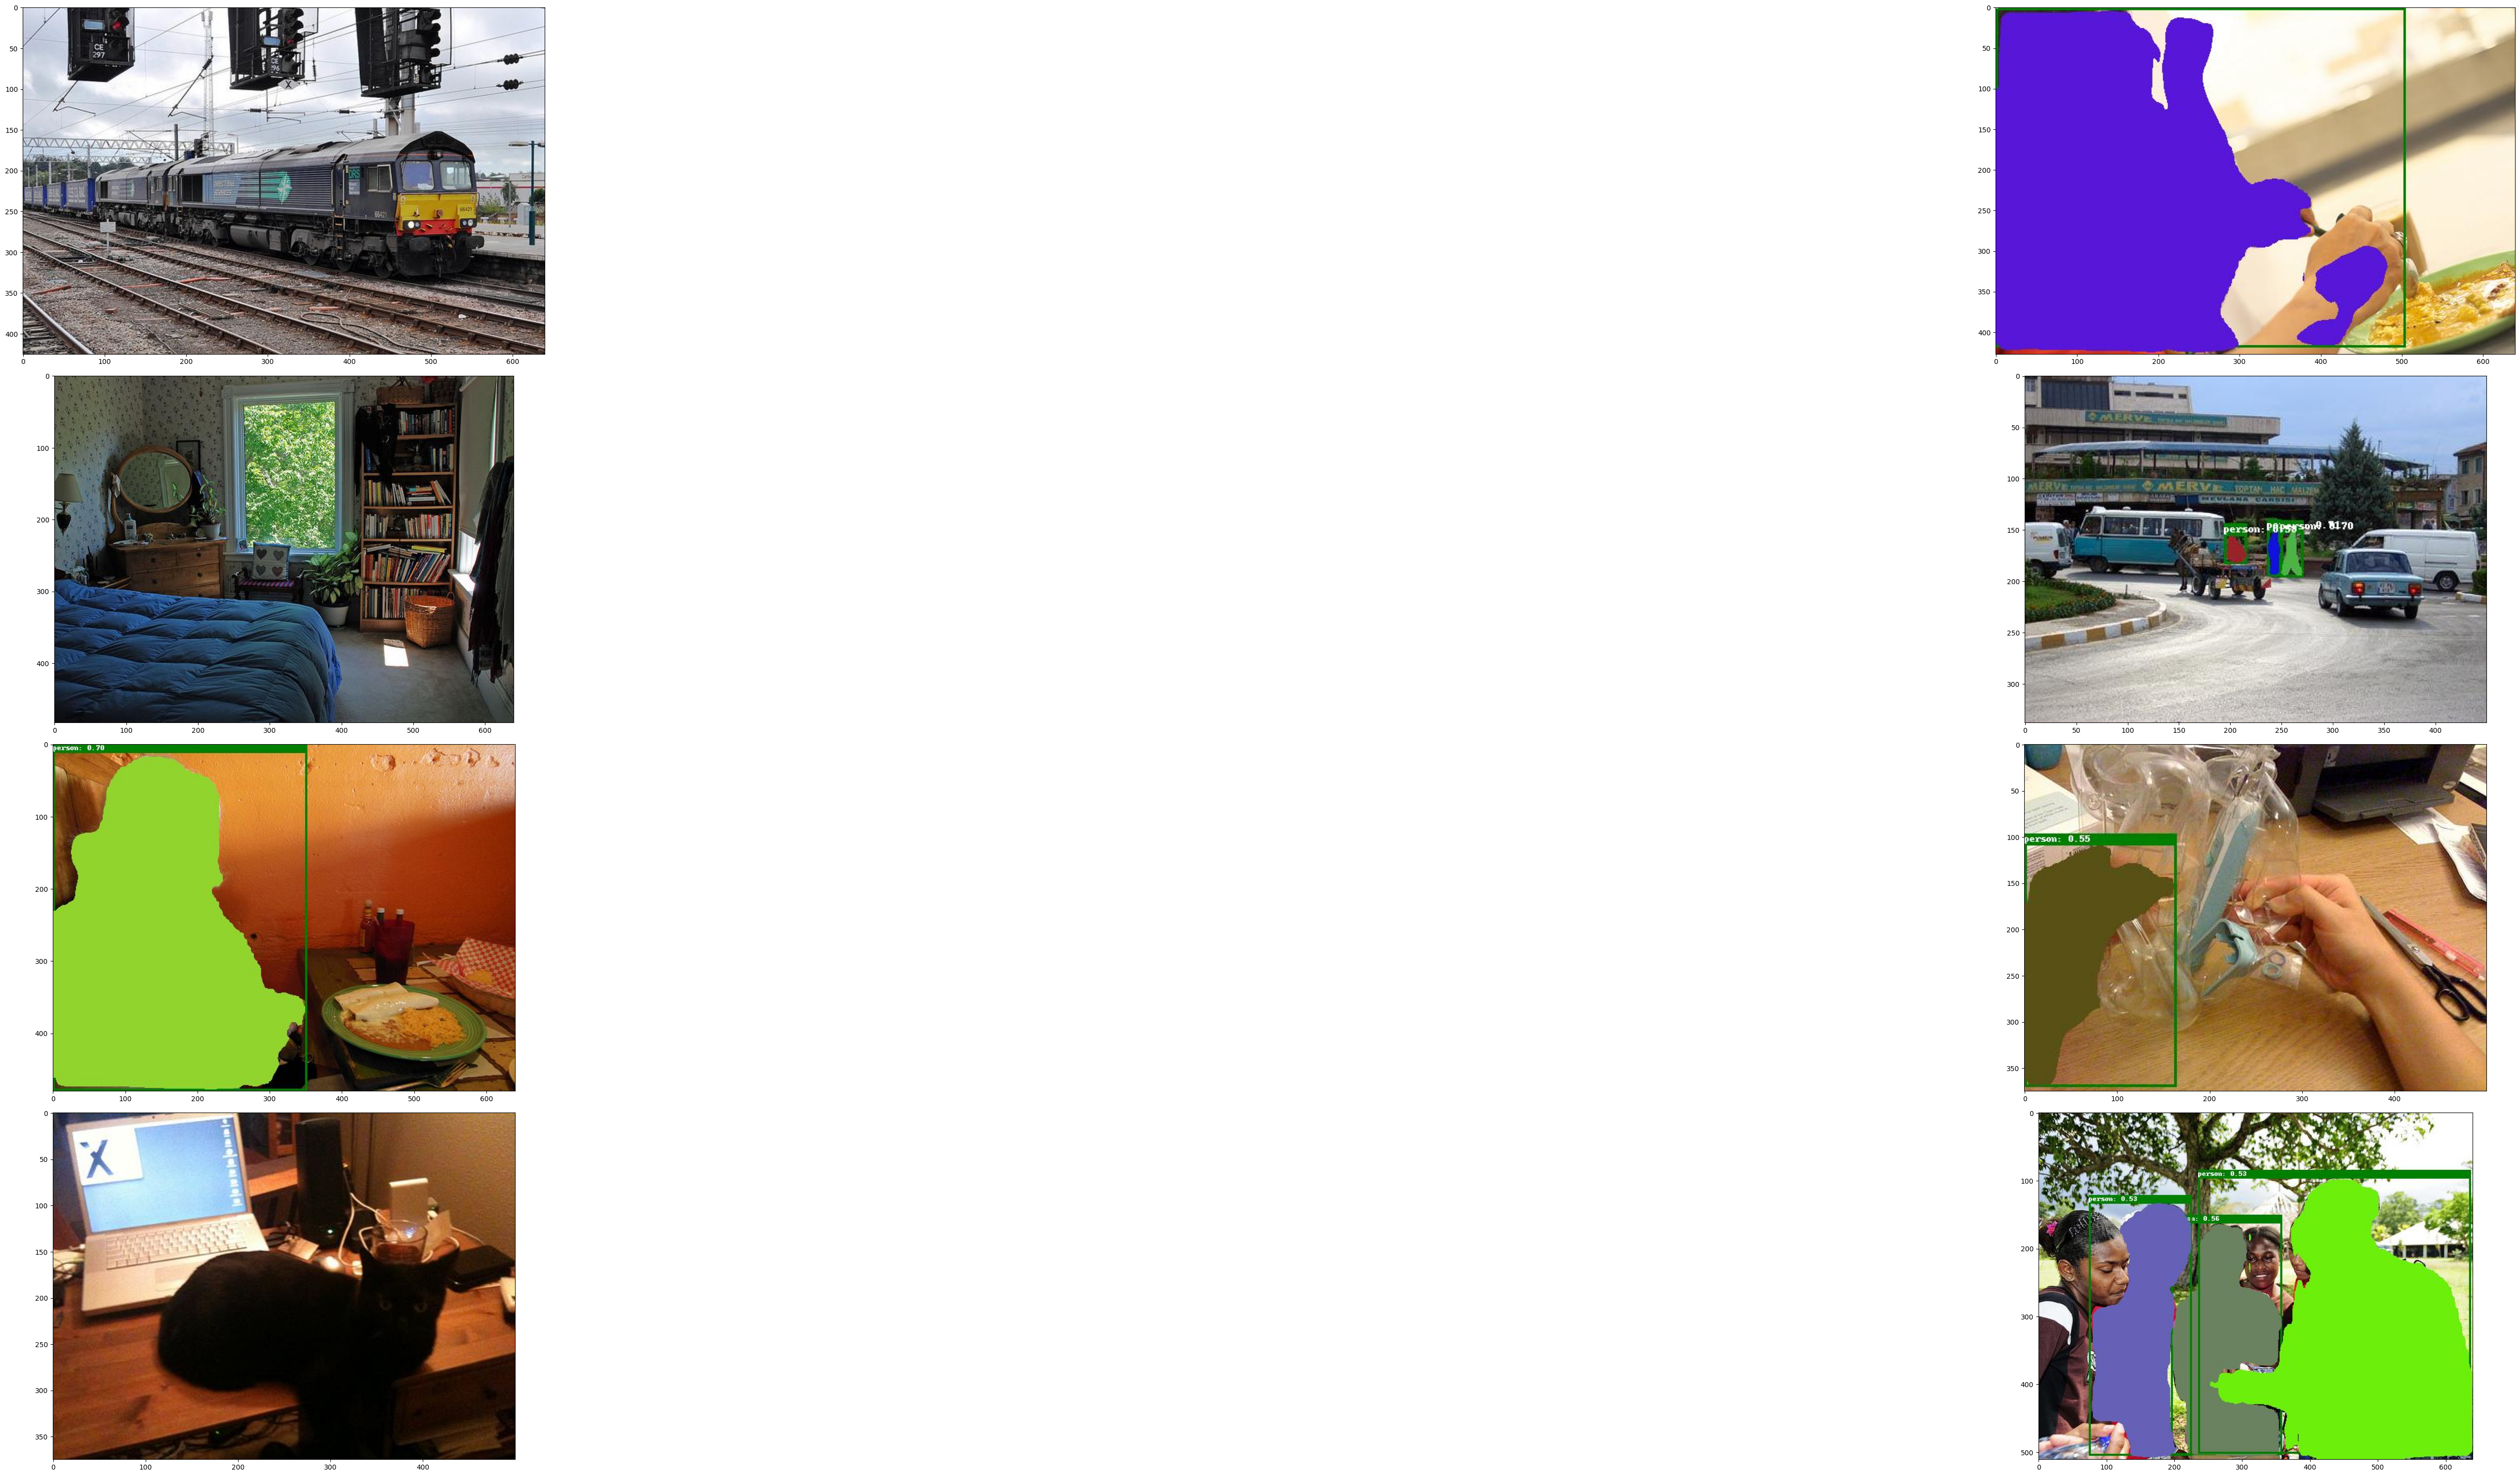

In [26]:
# Visualizing the sample images.
IMAGE_DIR = os.path.join(os.environ['HOST_RESULTS_DIR'], "inference", "images_annotated")
COLS = 2 # number of columns in the visualizer grid.
IMAGES = 8 # number of images to visualize.

visualize_images(IMAGE_DIR, num_cols=COLS, num_images=IMAGES)

## 7. Deploy (**experimental**) <a class="anchor" id="head-7"></a>

**Note:** The batch size of the exported ONNX model and TensorRT must be 1. 

In [27]:
# Export the model to ONNX model
!tao model mask_grounding_dino export \
           -e $SPECS_DIR/export.yaml \
           export.checkpoint=$RESULTS_DIR/train/mask_grounding_dino_model.pth \
           export.onnx_file=$RESULTS_DIR/export/mask_grounding_dino_model.onnx \
           results_dir=$RESULTS_DIR/

2024-11-16 23:18:18,743 [TAO Toolkit] [INFO] root 160: Registry: ['nvcr.io']
2024-11-16 23:18:18,818 [TAO Toolkit] [INFO] nvidia_tao_cli.components.instance_handler.local_instance 360: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:5.5.0-pyt
2024-11-16 23:18:18,835 [TAO Toolkit] [INFO] nvidia_tao_cli.components.docker_handler.docker_handler 301: Printing tty value True
sys:1: UserWarning: 
'export.yaml' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
/usr/local/lib/python3.10/dist-packages/nvidia_tao_pytorch/core/hydra/hydra_runner.py:107: UserWarning: 
'export.yaml' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/automatic_schema_matching for migr

In [ ]:
# Generate TensorRT engine using tao deploy
!tao deploy mask_grounding_dino gen_trt_engine -e $SPECS_DIR/gen_trt_engine.yaml \
                               gen_trt_engine.onnx_file=$RESULTS_DIR/export/mask_grounding_dino_model.onnx \
                               gen_trt_engine.trt_engine=$RESULTS_DIR/gen_trt_engine/mask_grounding_dino_model.engine \
                               results_dir=$RESULTS_DIR

In [29]:
# Inference with generated TensorRT engine
!tao deploy mask_grounding_dino inference -e $SPECS_DIR/infer.yaml \
                              inference.trt_engine=$RESULTS_DIR/gen_trt_engine/mask_grounding_dino_model.engine \
                              results_dir=$RESULTS_DIR/

2024-11-16 23:29:26,402 [TAO Toolkit] [INFO] root 160: Registry: ['nvcr.io']
2024-11-16 23:29:26,472 [TAO Toolkit] [INFO] nvidia_tao_cli.components.instance_handler.local_instance 360: Running command in container: nvcr.io/nvidia/tao/tao-toolkit:5.5.0-deploy
2024-11-16 23:29:26,499 [TAO Toolkit] [INFO] nvidia_tao_cli.components.docker_handler.docker_handler 301: Printing tty value True
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
sys:1: UserWarning: 
'infer.yaml' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/next/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
/usr/local/lib/pyth

In [ ]:
# Visualizing the sample images.
IMAGE_DIR = os.path.join(os.environ['HOST_RESULTS_DIR'], "trt_inference", "images_annotated")
COLS = 2 # number of columns in the visualizer grid.
IMAGES = 4 # number of images to visualize.

visualize_images(IMAGE_DIR, num_cols=COLS, num_images=IMAGES)

This notebook has come to an end.